# Quora Question Pairs

### Objectives

Identify which questions asked on Quora are duplicates of questions that have already been asked. This could be useful to instantly provide answers to questions that have already been answered. 

The task is to predict whether a pair of questions are duplicates or not. 

**Credits**: Kaggle (https://www.kaggle.com/c/quora-question-pairs)

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

#### Performance Metrics

Predictions are evaluated on the following metrics between the predicted values and the ground truth.

- Log Loss (https://www.kaggle.com/wiki/LogarithmicLoss)
- Binary Confusion Matrix

In [2]:
# importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
import pickle
import string
import unidecode

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from os import path
from wordcloud import WordCloud, STOPWORDS

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [3]:
# importing the dataset

df = pd.read_csv('train.csv')

In [4]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


We are given a minimal number of data fields here, consisting of:

- id:  A simple row ID
- qid1, qid2:  The unique ID of each question in the pair
- question1, question2:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

In [7]:
# drop ID fields

df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

### Exploratory Analysis

Distribution of data points

In [8]:
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

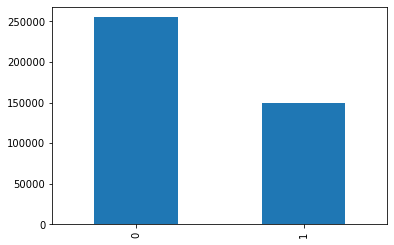

In [9]:
df['is_duplicate'].value_counts().plot.bar()

In [10]:
print("Total number of questions: {}".format(df.shape[0]))

Total number of questions: 404290


In [11]:
# number of duplicate and non-duplicate questions

print("Question pairs that are not similar (is_duplicate=0): {}".format(
    round((df['is_duplicate'] == 0).sum() * 100 / df.shape[0], 2)))

print("Question pairs that are similar (is_duplicate=1): {}".format(
round((df['is_duplicate'] == 1).sum() * 100 / df.shape[0], 2)))

Question pairs that are not similar (is_duplicate=0): 63.08
Question pairs that are similar (is_duplicate=1): 36.92


In [12]:
round((df['is_duplicate'] == 0).sum() / df.shape[0], 2)

0.63

In [13]:
# distribution of questions

questions = pd.concat([df['question1'], df['question2']])
questions_uniq = questions.unique()
questions_more_than_one = (questions.value_counts() > 1).sum()

print("Total number of questions: {}".format(questions.shape[0]))
print("Total number of unique questions: {}".format(questions_uniq.shape[0]))
print("Total number of duplicate questions occuring more than once: {} %".format(
    round(questions_more_than_one / questions_uniq.shape[0] * 100, 2)))
print("Maximum occurence of single repeated question: {}".format(questions.value_counts().max()))

Total number of questions: 808580
Total number of unique questions: 537361
Total number of duplicate questions occuring more than once: 20.82 %
Maximum occurence of single repeated question: 161


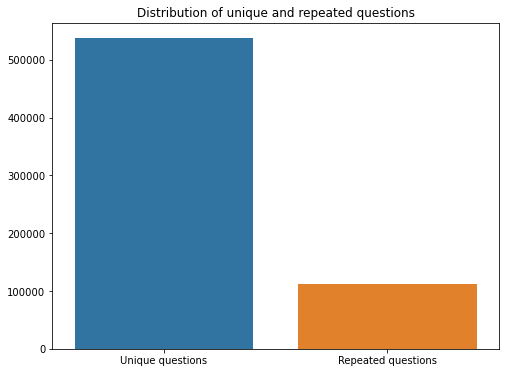

In [14]:
x = ['Unique questions', 'Repeated questions']
y = [questions_uniq.shape[0], questions_more_than_one]
plt.figure(figsize=(8, 6))
plt.title('Distribution of unique and repeated questions')
sns.barplot(x, y)
plt.show()

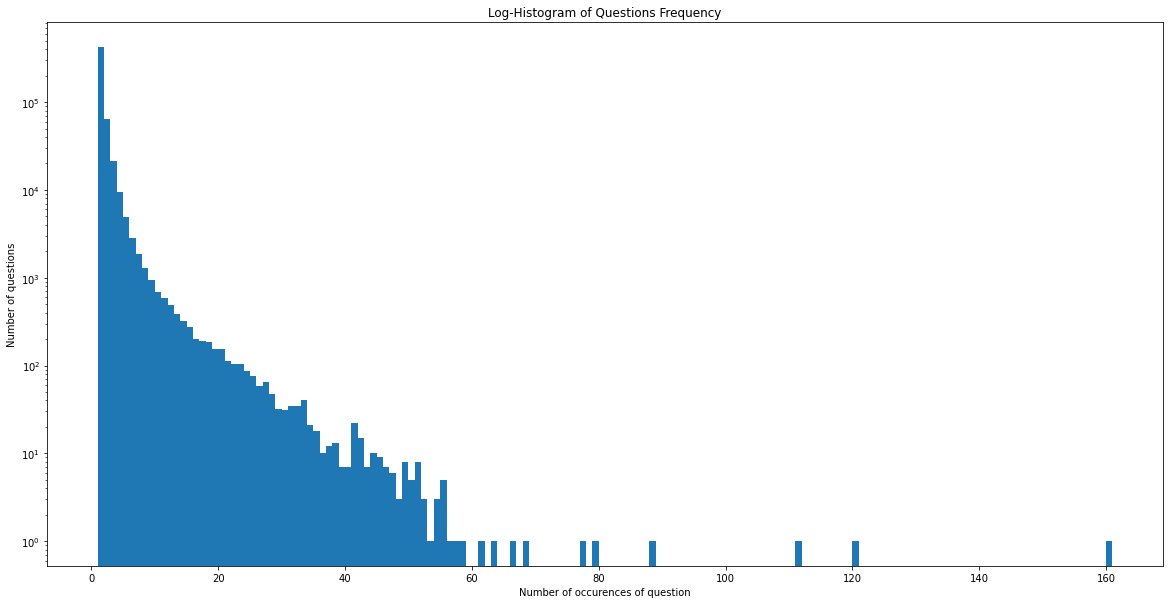

In [15]:
# histogram of questions frequency

plt.figure(figsize=(20, 10))
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Questions Frequency')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.hist(questions.value_counts(), bins=160)
plt.show()

In [16]:
# check missing values

df.isnull().sum()

question1       1
question2       2
is_duplicate    0
dtype: int64

In [17]:
# inspecting the empty rows

empty_rows = df[df.isnull().any(1)]
empty_rows

,question1,question2,is_duplicate
105780,How can I develop android app?,NaN,0
201841,How can I create an Android app?,NaN,0
363362,NaN,My Chinese name is Haichao Yu. What English na...,0


In [18]:
# deleting empty rows

df.drop(empty_rows.index, inplace=True)

### Feature extraction

- Number of characters in question1 and question2
- Number of words in question1 and question2
- Number of characters in question1 and question2 (removing whitespaces)
- Difference between number of characters in question1 and question2
- Difference between number of words in question1 and question2
- Difference between number of characters in question1 and question2 (removing whitespaces)
- Number of common words in question1 and question2
- Common words ratio i.e. Number of common words in question1 and question2 / Total number of words in question1 and question2

In [19]:
# extracting features from data

df['q1_len'] = df['question1'].apply(lambda x: len(x))
df['q2_len'] = df['question2'].apply(lambda x: len(x))
df['q1_word_len'] = df['question1'].apply(lambda x: len(x.split(' ')))
df['q2_word_len'] = df['question2'].apply(lambda x: len(x.split(' ')))
df['q1_char_len'] = df['question1'].apply(lambda x: len(x.replace(' ', '')))
df['q2_char_len'] = df['question2'].apply(lambda x: len(x.replace(' ', '')))
df['len_diff'] = df.apply(lambda x: abs(x['q1_len'] - x['q2_len']), axis=1)
df['word_len_diff'] = df.apply(lambda x: abs(x['q1_word_len'] - x['q2_word_len']), axis=1)
df['char_len_diff'] = df.apply(lambda x: abs(x['q1_char_len'] - x['q2_char_len']), axis=1)
df['common_words'] = df.apply(lambda x: len(
    set(x['question1'].lower().split(' ')) & set(x['question2'].lower().split(' '))), axis=1)
df['common_words_ratio'] = df.apply(lambda x: x['common_words'] / (x['q1_word_len'] + x['q2_word_len']), axis=1)

In [20]:
df.iloc[:, 2:].head()

,is_duplicate,q1_len,q2_len,q1_word_len,q2_word_len,q1_char_len,q2_char_len,len_diff,word_len_diff,char_len_diff,common_words,common_words_ratio
0,0,66,57,14,12,53,46,9,2,7,10,0.384615
1,0,51,88,8,13,44,76,37,5,32,4,0.190476
2,0,73,59,14,10,60,50,14,4,10,4,0.166667
3,0,50,65,11,9,40,57,15,2,17,0,0.000000
4,0,76,39,13,7,64,33,37,6,31,2,0.100000


In [21]:
print("Minimum length of the questions in question 1: {}".format(min(df['q1_len'])))
print("Minimum length of the questions in question 2: {}".format(min(df['q2_len'])))

print("Number of questions with minimum length in question 1: {}".format((df['q1_len'] == 1).sum()))
print("Number of questions with minimum length in question 2: {}".format((df['q2_len'] == 1).sum()))

Minimum length of the questions in question 1: 1
Minimum length of the questions in question 2: 1
Number of questions with minimum length in question 1: 19
Number of questions with minimum length in question 2: 2


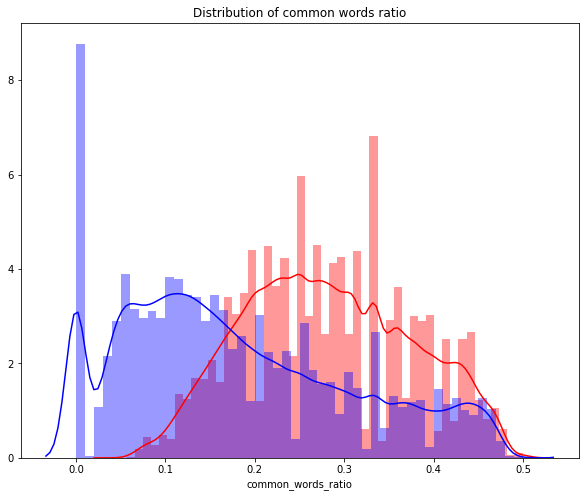

In [22]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of common words ratio')
sns.distplot(df[df['is_duplicate'] == 1]['common_words_ratio'], label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['common_words_ratio'], label = "0", color = 'blue')
plt.show()

### Text Preprocessing

- Remove HTML tags
- Remove extra whitespaces
- Convert accented characters to ASCII characters
- Expand contractions
- Remove special characters
- Lowercase all texts
- Remove stopwords
- Lemmatization

In [23]:
# remove html tags from text

def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

remove_html_tags("<p>This is a paragraph</p>")

'This is a paragraph'

In [24]:
# words with accent marks like 'latté' and 'café' can be converted and standardized to just 'latte' and 'cafe'

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

remove_accented_chars('latté')

'latte'

In [25]:
# expand contractions

cList = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expand_contractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

print(expand_contractions('I ain\'t got time for y\'alls foolishness'))
print(expand_contractions('You won\'t live to see tomorrow.'))

I am not got time for you alls foolishness
You will not live to see tomorrow.


In [26]:
# remove comma between numbers

def remove_comma_between_numbers(text):
    return re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

print(remove_comma_between_numbers("15,000"))
print(remove_comma_between_numbers("lorem ipsum 1,00,000"))

15000
lorem ipsum 100000


In [27]:
# load stop words and stemmer

stop_words = set(stopwords.words('english')) 
porter = PorterStemmer()

In [28]:
def clean(text, remove_html=True, remove_punctuation=True):

    text = text.lower()

    if remove_html:
        text = remove_html_tags(text)

    text = remove_accented_chars(text)
    text = expand_contractions(text)
    text = remove_comma_between_numbers(text)

    # remove punctuation (optional)
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # remove stop words
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]

    # stemming using porter
    stemmed_text = [porter.stem(w) for w in filtered_text]
    text = ' '.join(filtered_text)

    return text

In [29]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

In [30]:
for i in range(10):
    print(df.question1[i])
    print(df.question2[i])
    print('')

step step guide invest share market india
step step guide invest share market

story kohinoor kohinoor diamond
would happen indian government stole kohinoor kohinoor diamond back

increase speed internet connection using vpn
internet speed increased hacking dns

mentally lonely solve
find remainder math2324math divided 2423

one dissolve water quikly sugar salt methane carbon di oxide
fish would survive salt water

astrology capricorn sun cap moon cap risingwhat say
im triple capricorn sun moon ascendant capricorn say

buy tiago
keeps childern active far phone video games

good geologist
great geologist

use shi instead shi
use instead

motorola company hack charter motorolla dcx3400
hack motorola dcx3400 free internet



In [31]:
df_duplicate = df[df['is_duplicate'] == 1]
df_non_duplicate = df[df['is_duplicate'] == 0]

In [32]:
# merge question1 and question2 in duplicate and non_duplocate dataset

p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_non_duplicate["question1"], df_non_duplicate["question2"]]).flatten()

print("Number of data points in class 1 (duplicate pairs): ", len(p))
print("Number of data points in class 0 (non duplicate pairs): ", len(n))

# saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs):  298526
Number of data points in class 0 (non duplicate pairs):  510048


In [33]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 9951438
Total number of words in non duplicate pair questions : 20830838


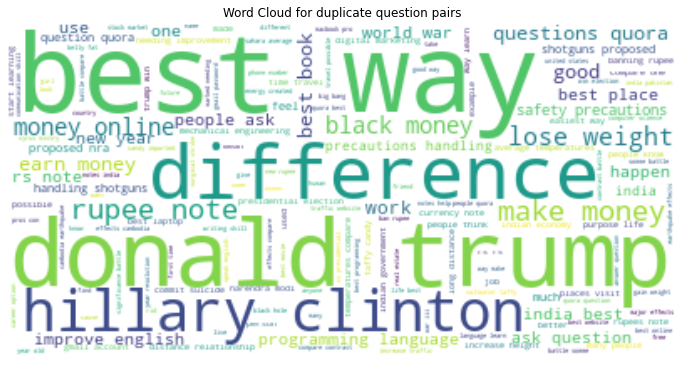

In [34]:
# word cloud for duplicate questions pair

plt.figure(figsize=(12, 8))
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
plt.title("Word Cloud for duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

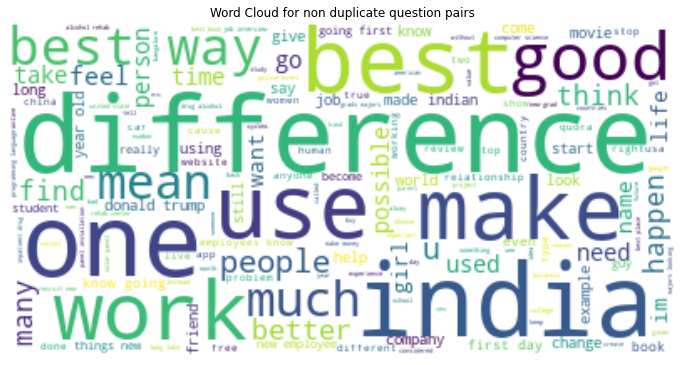

In [35]:
# word cloud for non duplicate questions pair

plt.figure(figsize=(12, 8))
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
plt.title("Word Cloud for non duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Advanced Feature Extraction

#### FuzzyWuzzy

The following text ratio can be extracted from the fuzzywuzzy library.

- Fuzz Ratio
- Fuzz Parial Ratio
- Token Sort Ratio
- Token Set Ratio

**Credits:**
<br>
https://github.com/seatgeek/fuzzywuzzy
<br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


In [36]:
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(x['question1'], x['question2']), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)

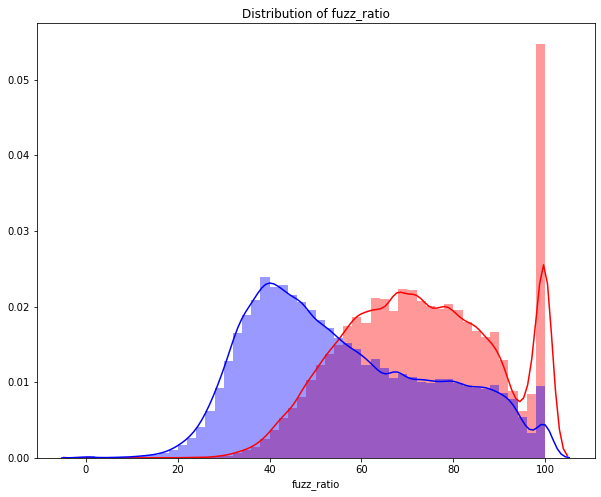

In [37]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of fuzz_ratio')
sns.distplot(df[df['is_duplicate'] == 1]['fuzz_ratio'], label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['fuzz_ratio'], label = "0", color = 'blue')
plt.show()

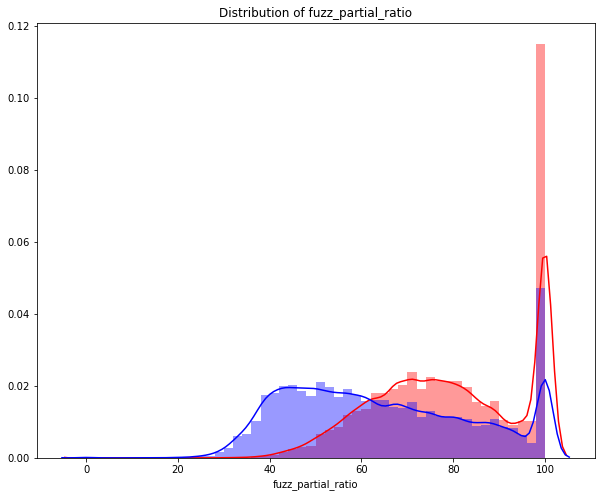

In [38]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of fuzz_partial_ratio')
sns.distplot(df[df['is_duplicate'] == 1]['fuzz_partial_ratio'], label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['fuzz_partial_ratio'], label = "0", color = 'blue')
plt.show()

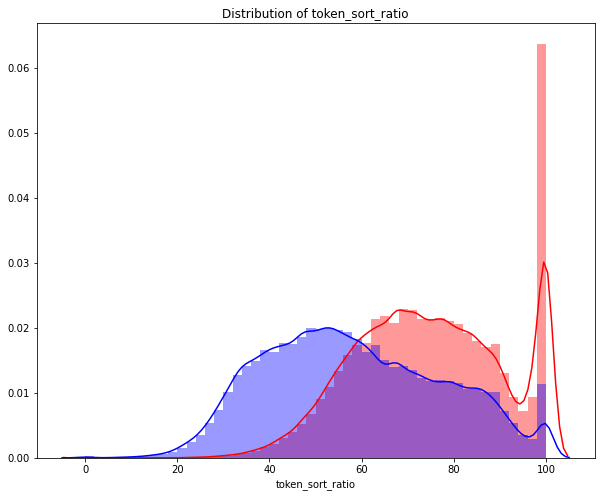

In [39]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of token_sort_ratio')
sns.distplot(df[df['is_duplicate'] == 1]['token_sort_ratio'], label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['token_sort_ratio'], label = "0", color = 'blue')
plt.show()

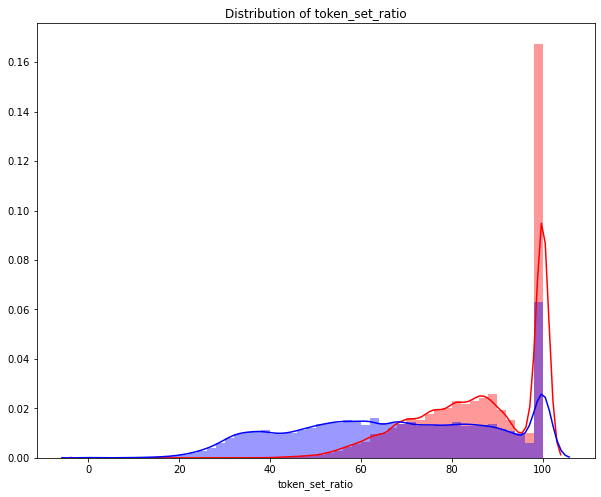

In [40]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of token_set_ratio')
sns.distplot(df[df['is_duplicate'] == 1]['token_set_ratio'], label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['token_set_ratio'], label = "0", color = 'blue')
plt.show()

In [41]:
df.head(10)

,question1,question2,is_duplicate,q1_len,q2_len,q1_word_len,q2_word_len,q1_char_len,q2_char_len,len_diff,word_len_diff,char_len_diff,common_words,common_words_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,step step guide invest share market india,step step guide invest share market,0,66,57,14,12,53,46,9,2,7,10,0.384615,92,100,92,100
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,51,88,8,13,44,76,37,5,32,4,0.190476,59,94,59,84
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,73,59,14,10,60,50,14,4,10,4,0.166667,55,56,70,70
3,mentally lonely solve,find remainder math2324math divided 2423,0,50,65,11,9,40,57,15,2,17,0,0.000000,23,29,23,23
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,76,39,13,7,64,33,37,6,31,2,0.100000,43,52,40,51
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,86,90,16,16,71,75,4,0,4,8,0.250000,64,65,60,69
6,buy tiago,keeps childern active far phone video games,0,19,62,4,11,16,52,43,7,36,0,0.000000,19,33,19,19
7,good geologist,great geologist,1,30,41,7,9,24,33,11,2,9,4,0.250000,76,71,76,78
8,use shi instead shi,use instead,0,31,37,8,8,24,30,6,0,6,6,0.375000,73,82,73,100
9,motorola company hack charter motorolla dcx3400,hack motorola dcx3400 free internet,0,60,49,9,9,52,41,11,0,11,3,0.166667,51,60,59,75


In [42]:
# saving the data

df.to_pickle("questions_preprocessed.pkl")